<a href="https://colab.research.google.com/github/raphaelp-silva/GNN_Pytorch_geometric/blob/main/GNN_esquizofrenia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Etapa 1: instalando bibliotecas

In [1]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.3 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import kagglehub
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import networkx as nx
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from torch_geometric.utils import from_scipy_sparse_matrix

## Etapa 2: explorando e ajustando a base de dados

In [3]:
# Base de dados disponivel em: https://www.kaggle.com/datasets/asinow/schizohealth-dataset?resource=download

base = pd.read_csv('/content/schizophrenia_dataset.csv')

In [4]:
np.random.seed(123)
torch.manual_seed(123)

In [5]:
base.head()

,Hasta_ID,Yaş,Cinsiyet,Eğitim_Seviyesi,Medeni_Durum,Meslek,Gelir_Düzeyi,Yaşadığı_Yer,Tanı,Hastalık_Süresi,Hastaneye_Yatış_Sayısı,Ailede_Şizofreni_Öyküsü,Madde_Kullanımı,İntihar_Girişimi,Pozitif_Semptom_Skoru,Negatif_Semptom_Skoru,GAF_Skoru,Sosyal_Destek,Stres_Faktörleri,İlaç_Uyumu
0,1,72,1,4,2,0,2,1,0,0,0,0,0,0,32,48,72,0,2,2
1,2,49,1,5,2,2,1,0,1,35,1,1,1,1,51,63,40,2,2,0
2,3,53,1,5,3,2,1,0,1,32,0,1,0,0,72,85,51,0,1,1
3,4,67,1,3,2,0,2,0,0,0,0,0,1,0,10,21,74,1,1,2
4,5,54,0,1,2,0,2,1,0,0,0,0,0,0,4,27,98,0,1,0


In [6]:
# Renomeando as colunas:
base.columns = ['ID_paciente', 'Idade', 'Gênero', 'Nivel_educ', 'Estado_civ', 'Profissao', 'Nivel_renda', 'Area_habitacao', 'Diagnostico', 'Duração_doença', 'N_hospitalizacao', 'Hist_familiar', 'Uso_subst', 'Temperamento_suic', 'Score_sintomas_positivos', 'Score_sintomas_negativos', 'GAF_score', 'Suporte_social', 'Fator_estresse', 'Adesao_medicação']

In [7]:
base.head()

,ID_paciente,Idade,Gênero,Nivel_educ,Estado_civ,Profissao,Nivel_renda,Area_habitacao,Diagnostico,Duração_doença,N_hospitalizacao,Hist_familiar,Uso_subst,Temperamento_suic,Score_sintomas_positivos,Score_sintomas_negativos,GAF_score,Suporte_social,Fator_estresse,Adesao_medicação
0,1,72,1,4,2,0,2,1,0,0,0,0,0,0,32,48,72,0,2,2
1,2,49,1,5,2,2,1,0,1,35,1,1,1,1,51,63,40,2,2,0
2,3,53,1,5,3,2,1,0,1,32,0,1,0,0,72,85,51,0,1,1
3,4,67,1,3,2,0,2,0,0,0,0,0,1,0,10,21,74,1,1,2
4,5,54,0,1,2,0,2,1,0,0,0,0,0,0,4,27,98,0,1,0


In [8]:
base.shape

(10000, 20)

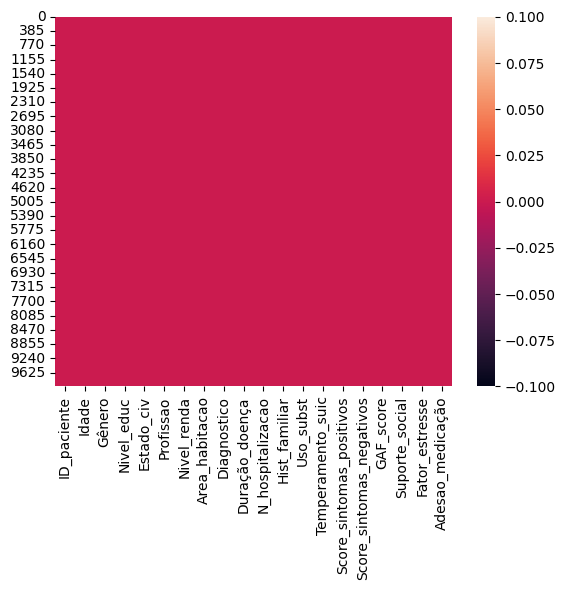

In [9]:
# verificando se existe valores nulos na base:
sns.heatmap(base.isnull());

In [10]:
# retirando colunas com menor relevância em nossa análise:

base = base.drop('Nivel_educ', axis = 1)
base = base.drop('Estado_civ', axis = 1)
base = base.drop('Profissao', axis = 1)
base = base.drop('Nivel_renda', axis = 1)
base = base.drop('Area_habitacao', axis = 1)
base = base.drop('ID_paciente', axis = 1)


In [11]:
base.head()

,Idade,Gênero,Diagnostico,Duração_doença,N_hospitalizacao,Hist_familiar,Uso_subst,Temperamento_suic,Score_sintomas_positivos,Score_sintomas_negativos,GAF_score,Suporte_social,Fator_estresse,Adesao_medicação
0,72,1,0,0,0,0,0,0,32,48,72,0,2,2
1,49,1,1,35,1,1,1,1,51,63,40,2,2,0
2,53,1,1,32,0,1,0,0,72,85,51,0,1,1
3,67,1,0,0,0,0,1,0,10,21,74,1,1,2
4,54,0,0,0,0,0,0,0,4,27,98,0,1,0


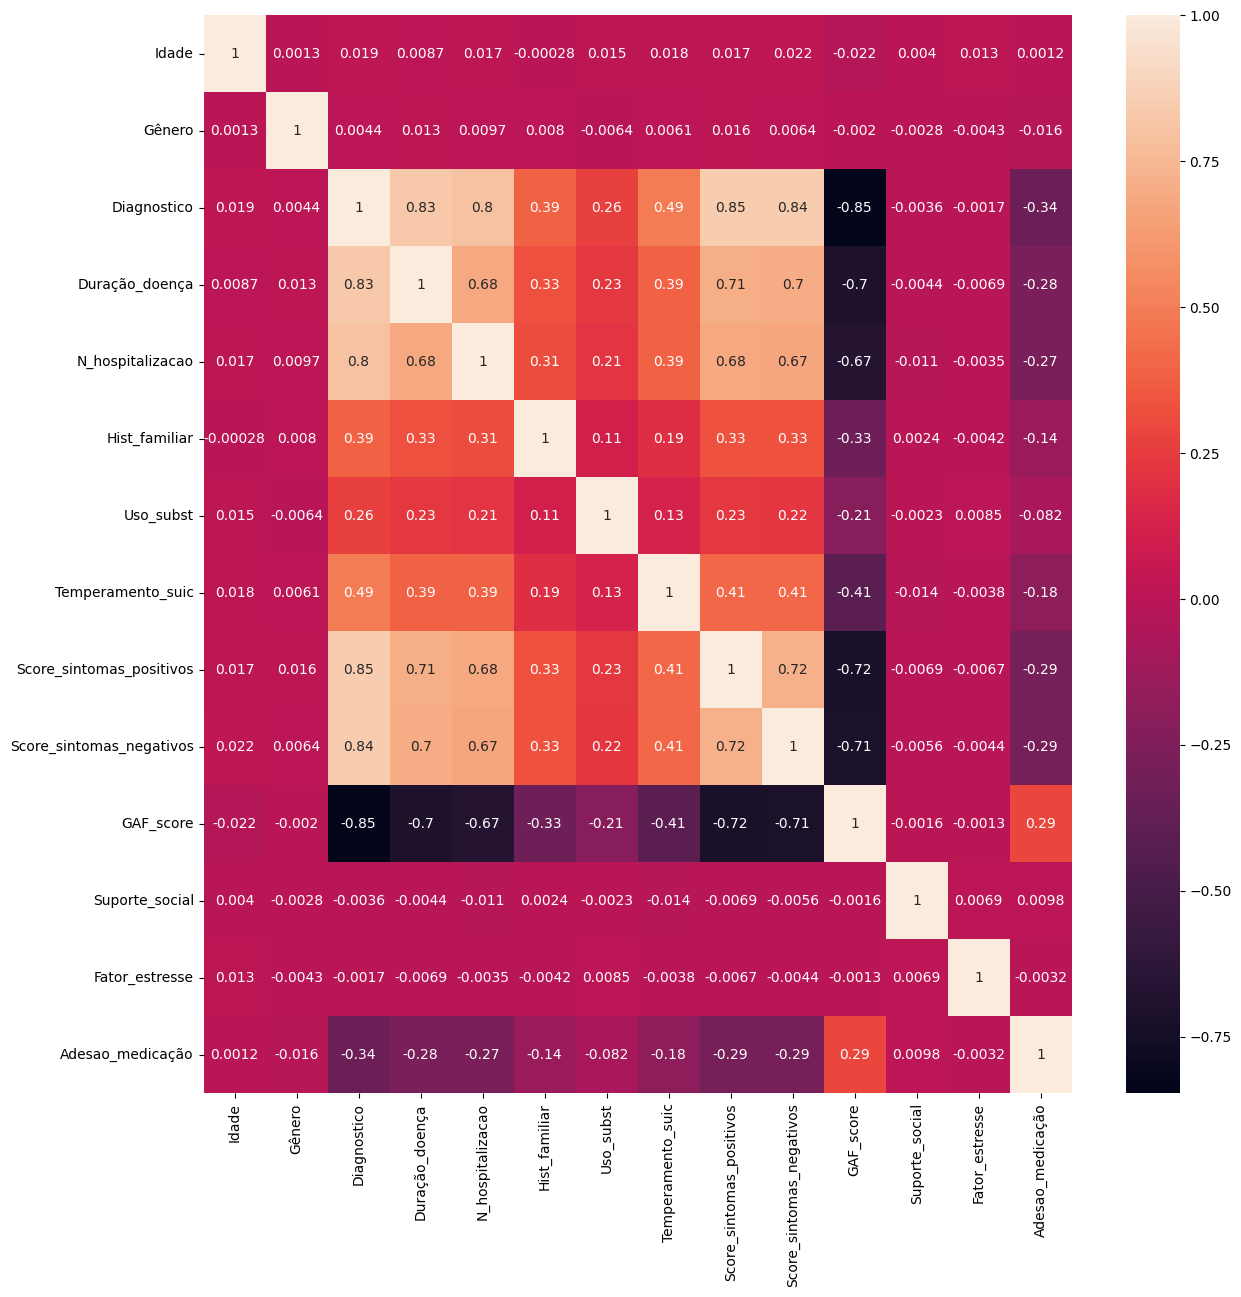

In [12]:
f, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(base.corr(), annot = True);

In [13]:
previsores = base.iloc[:, [0,1,3,4,5,6,7,8,9,10,11,12,13]].values
classe = base.iloc[:, 2].values

## Etapa 3: Transformando e dividindo os dados para teste e treinamento

In [14]:
previsores = torch.tensor(previsores, dtype = torch.float) # x, matriz de features
classe = torch.tensor(classe, dtype = torch.long) # y, rótulo dos nós

knn_graph = kneighbors_graph(previsores, 10, mode = 'connectivity') # gerando a matriz de vizinhos mais próximos em formato esparso.
non_zero_indices = knn_graph.nonzero() # retornando os indices não nulos de uma matriz esparsa.
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long) # convertendo para o tensor esparso no fomato 2,num_edges.

In [15]:
# Dividindo os dados em treino e teste:
#X_train, X_test, y_train, y_test = train_test_split(previsores, classe, test_size=0.2, random_state=42, stratify = classe)

num_nodes = previsores.size(0)
indices = torch.randperm(num_nodes)
train_size = int(0.8 * num_nodes)
train_indices, test_indices = indices[:train_size], indices[train_size:]

X_train, X_test = previsores[train_indices], previsores[test_indices]
y_train, y_test = classe[train_indices], classe[test_indices]


# Função para gerar um novo edge_index para cada conjunto (train/test):
def generate_edge_index(features, n_neighbors = 10):

    # Converte as features para NumPy e gera o grafo KNN
    knn_graph = kneighbors_graph(features.numpy(), n_neighbors=n_neighbors, mode='connectivity', include_self=False)
    # Converte a matriz esparsa para edge_index (e atributos, que descartamos)
    edge_index, _ = from_scipy_sparse_matrix(knn_graph)
    return edge_index

# Gerando um novo edge_index para cada conjunto
edge_index_train = generate_edge_index(X_train, n_neighbors = 10)
edge_index_test = generate_edge_index(X_test, n_neighbors = 10)

# Criando o Data para treino e teste
train_data = Data(x=X_train, edge_index=edge_index_train, y=y_train)
test_data = Data(x=X_test, edge_index=edge_index_test, y=y_test)

train_loader = DataLoader([train_data], batch_size=1, shuffle=True)
test_loader = DataLoader([test_data], batch_size=1, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Etapa 4: Criando a rede

In [16]:
# Criando a rede:
class GNN(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(GNN, self).__init__()
    self.conv1 = GCNConv(input_dim, hidden_dim)
    self.conv2 = GCNConv(hidden_dim, output_dim)
    self.dropout = torch.nn.Dropout(0.5)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.conv2(x, edge_index)
    return F.log_softmax(x, dim=1)

#criando o modelo:
input_dim = previsores.shape[1]
hidden_dim = 8
output_dim = 2

model = GNN(input_dim, hidden_dim, output_dim)

## Etapa 5: Treinando a rede

In [31]:
# definindo otimizador e função de perda:
from torch_geometric.utils import add_self_loops

# Função para adicionar arestas aleatórias ao grafo
def add_random_edges(edge_index, num_nodes, add_prob=0.1):
    num_edges_to_add = int(edge_index.shape[1] * add_prob)  # Define quantas arestas adicionar
    new_edges = torch.randint(0, num_nodes, (2, num_edges_to_add))  # Gera novas conexões aleatórias
    return torch.cat([edge_index, new_edges], dim=1)  # Concatena as novas arestas



optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.NLLLoss()

# função de treino:
def train():
  model.train()
  total_loss = 0
  for batch in train_loader:
    optimizer.zero_grad()

    # aplicando a perturbação nas features dos nós
    batch.edge_index = add_random_edges(batch.edge_index, batch.num_nodes, add_prob=0.1)


    out = model(batch)
    loss = loss_fn(out, batch.y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    return total_loss / len(train_loader)

for epoch in range (100):
  loss = train()
  if epoch % 10 == 0 :
    print(f'época {epoch}, Loss: {loss:.4f}')

época 0, Loss: 0.0254
época 10, Loss: 0.0324
época 20, Loss: 0.0215
época 30, Loss: 0.0113
época 40, Loss: 0.0132
época 50, Loss: 0.0149
época 60, Loss: 0.0142
época 70, Loss: 0.0112
época 80, Loss: 0.0050
época 90, Loss: 0.0028


## Etapa 6: Avaliando os resultados

In [43]:
def test(model, test_loader):
    model.eval()  # Coloca o modelo em modo de avaliação
    correct = 0
    total = 0

    with torch.no_grad():  # Não precisa calcular gradientes
        for batch in test_loader:
            out = model(batch)  # Faz a predição
            pred = out.argmax(dim=1)  # Obtém a classe predita (maior probabilidade)

            y_true = batch.y.view(-1)

            # Debugging: Imprime algumas previsões e valores reais
            print(f"Pred: {pred.tolist()}")
            print(f"True: {y_true.tolist()}")

            correct += (pred == y_true).sum().item()  # Conta acertos
            total += y_true.size(0)  # Conta total de exemplos

    accuracy = correct / total if total > 0 else 0 # Calcula acurácia
    return accuracy

# Chamando a função de teste
accuracy = test(model, test_loader)
print(f"Acurácia do modelo nos dados de teste: {accuracy:.4f}")

Pred: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Pred: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

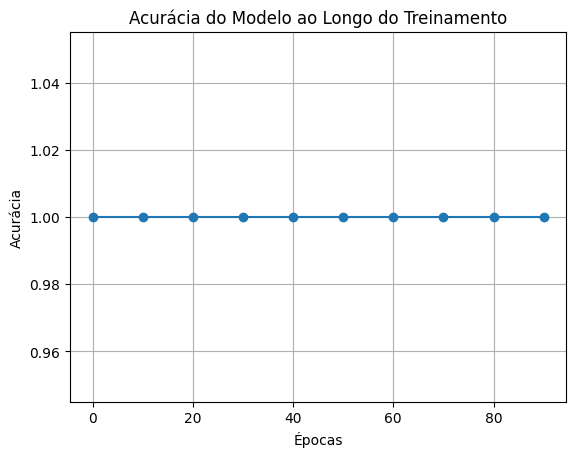

In [44]:
accuracy_history = []

# Testando o modelo em cada época
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        accuracy = test(model, test_loader)
        accuracy_history.append(accuracy)
        print(f'Época {epoch}, Loss: {loss:.4f}, Acurácia: {accuracy:.4f}')

# Criando o gráfico de acurácia
plt.plot(range(0, 100, 10), accuracy_history, marker='o', linestyle='-')
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.title("Acurácia do Modelo ao Longo do Treinamento")
plt.grid()
plt.show()

In [45]:
print(f"Tamanho do treino: {len(y_train)}, Tamanho do teste: {len(y_test)}")
print(f"Classes no treino: {torch.bincount(y_train)}")
print(f"Classes no teste: {torch.bincount(y_test)}")


Tamanho do treino: 8000, Tamanho do teste: 2000
Classes no treino: tensor([5673, 2327])
Classes no teste: tensor([1440,  560])


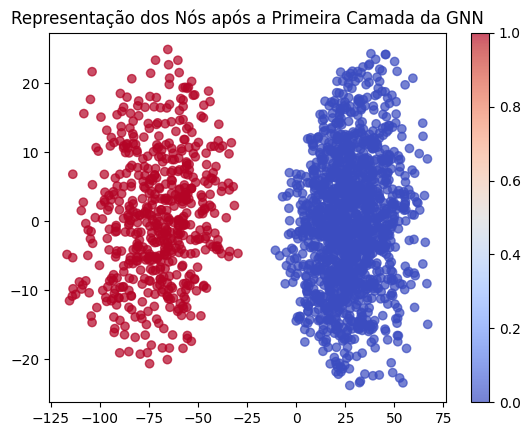

In [46]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

model.eval()
with torch.no_grad():
    embeddings = model.conv1(test_data.x, test_data.edge_index).numpy()

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.scatter(reduced[:, 0], reduced[:, 1], c=test_data.y.numpy(), cmap='coolwarm', alpha=0.7)
plt.colorbar()
plt.title("Representação dos Nós após a Primeira Camada da GNN")
plt.show()


#### O gráfico acima mostra uma separação clara entre as duas classes, o que pode indicar que o modelo está memorizando os dados em vez de aprender padrões generalizáveis. Isso reforça hipótese de overfitting ou data leakage.

In [47]:
# testando se o dataset de treinamento e teste são diferentes:

train_indices_set = set(train_indices.tolist())
test_indices_set = set(test_indices.tolist())

overlap = train_indices_set.intersection(test_indices_set)

print(f'treino e teste compartilham {len(overlap)} exemplos.')

treino e teste compartilham 0 exemplos.


In [51]:
# Gerando amostras aleatórias
X_random = previsores.mean(dim=0) + torch.randn_like(previsores) * previsores.std(dim=0)
y_random = torch.randint(low=0, high=2, size=(X_random.shape[0],))

# Criando um DataLoader falso
random_data = Data(x=X_random, edge_index=generate_edge_index(X_random), y=y_random)
random_loader = DataLoader([random_data], batch_size=1, shuffle=False)

# Testando o modelo com dados novos
accuracy_random = test(model, random_loader)
print(f"Acurácia com dados novos: {accuracy_random:.4f}")


Pred: [0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [26]:
from collections import Counter

# Contar distribuição de classes nos dados de treino
train_labels = [batch.y.tolist() for batch in train_loader]
train_labels = [y for sublist in train_labels for y in sublist]  # Flatten lista de listas
print("Distribuição no treino:", Counter(train_labels))

# Contar distribuição nos dados aleatórios
random_labels = Counter(y_random.tolist())
print("Distribuição nas amostras aleatórias:", random_labels)


Distribuição no treino: Counter({0: 5673, 1: 2327})
Distribuição nas amostras aleatórias: Counter({1: 5129, 0: 4871})


In [27]:
num_class_0 = sum(1 for batch in train_loader for y in batch.y if y == 0)
num_class_1 = sum(1 for batch in train_loader for y in batch.y if y == 1)

print(f"Exemplos de Classe 0: {num_class_0}, Classe 1: {num_class_1}")


Exemplos de Classe 0: 5673, Classe 1: 2327


In [28]:
real_data = torch.cat([batch.x for batch in train_loader], dim=0)

print("Média real:", real_data.mean(dim=0))
print("Média aleatória:", X_random.mean(dim=0))
print("Desvio padrão real:", real_data.std(dim=0))
print("Desvio padrão aleatório:", X_random.std(dim=0))


Média real: tensor([49.0474,  0.5016,  5.9190,  1.4536,  0.3199,  0.2196,  0.0900, 39.2381,
        39.5366, 66.9731,  0.9924,  1.0010,  1.1349])
Média aleatória: tensor([49.0588,  0.4975,  5.7875,  1.4731,  0.3181,  0.2174,  0.0935, 38.8881,
        39.3605, 66.8737,  0.9967,  0.9946,  1.1362])
Desvio padrão real: tensor([18.1502,  0.5000, 11.1044,  2.8317,  0.4665,  0.4140,  0.2862, 27.3134,
        26.9498, 24.1019,  0.8128,  0.8161,  0.8221])
Desvio padrão aleatório: tensor([18.3813,  0.5011, 11.2212,  2.8506,  0.4691,  0.4148,  0.2881, 27.1874,
        26.9618, 23.7150,  0.8099,  0.8178,  0.8219])
